<a href="https://colab.research.google.com/github/ucheokechukwu/Active-Learning-on-the-Titanic/blob/main/Pytorch_For_Deep_Learning/01_workflow_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build model",
                      3: "fitting the model to data (training)",
                      4: "making predictions and evaluating the model (inferences)",
                      5: "saving and loading a model",
                      6: "putting it all together"}


In [2]:
import torch
from torch import nn # building blocks of graphs (neural networks)
import matplotlib.pyplot as plt

# check pytorch version
torch.__version__

'2.0.1+cu118'

In [3]:
!nvidia-smi

Wed Aug  2 15:00:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data

## turning our data into tensors

In [4]:
# create *known* parameters
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

## splitting data into training and testing

In [5]:
# splitting the data into training and sets
train_split = int(0.8*len(X))
X_train, y_train, X_test, y_test = X[:train_split], y[:train_split], X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [6]:
def plot_predictions(train_data = X_train,
                     train_label = y_train,
                     test_data = X_test,
                     test_label = y_test,
                     predictions=None):
    """plots training data, test data, and compares predictions"""
    plt.figure(figsize=(10,7))
    plt.scatter(train_data, train_label, c= 'b', s=4, label="Training data")
    plt.scatter(test_data, test_label, c= 'g', s=4, label="Testing data")


    if predictions is not None:
        plt.scatter(test_data, predictions, c= 'r', s=4, label="Predictions")

    plt.legend(prop={'size':14})

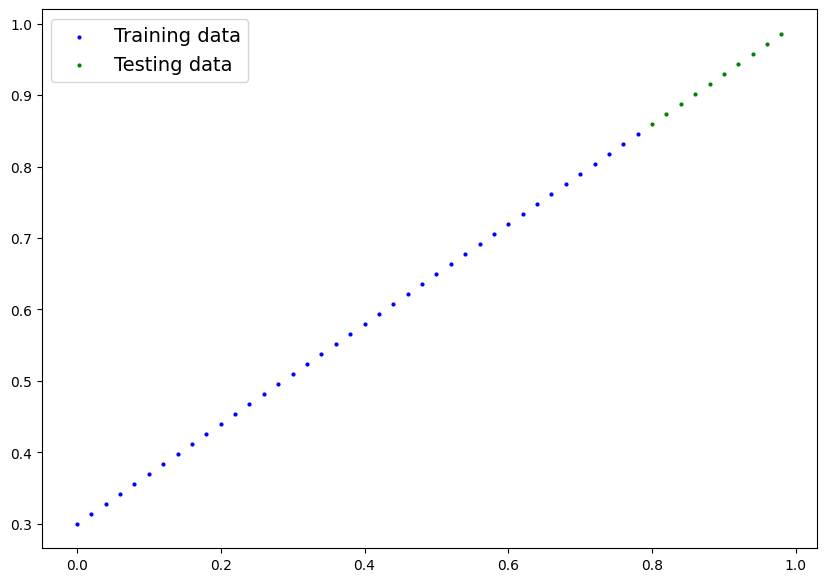

In [7]:
plot_predictions()

# 2. Build Model

What our model does:
1. starts with random values (weight and bias),
2. look at training data nad adjust the random values to better represent the ideal values (i.e. weight and biase used to create data)

how does it do so? 2 main algorithms:
1. gradient descent
2. back propagations

In [8]:
from torch import nn
# create a linear regression model class

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()

        # initialize the model parameters (could be single parameters, layers or functions)
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float))

    # forward method to define the computation in the model
    # need to override the forward method of nn.Module
    def forward(self, x:torch.Tensor) -> torch.Tensor:  # input is x of type torch.Tensor and returns type torch.Tensor
        return self.weights * x + self.bias


### pytorch model building essentials

* `torch.nn` - contains building blocks for computational graphs (neural networks)
* `torch.nn.Parameter` - parameters for the model to try and learn
* `torch.nn.Module` - base class
* `def forward` - all nn.Module submodules requre you to overwrite this
* `torch.optim `- optimizers, help with gradient descent
* `torch.utils.data.Dataset` - represents a map between key (label) and sample (features) pairs of data
* `torch.utils.data.Dataloader` - creates a python iterable over a torch Dataset (allows you to iterate over your data)


Pytorch cheat sheet: https://pytorch.org/tutorials/beginner/ptcheat.html


### checking the contents of the Pytorch model
- we can do this with `.parameters()`

In [103]:
# create a random seed
torch.manual_seed(88)

# create an instance of the model
model_0 = LinearRegressionModel()

# check out parameters
display(model_0.parameters()) # get a generator
list(model_0.parameters())

<generator object Module.parameters at 0x7db97e1199a0>

[Parameter containing:
 tensor([0.5734], requires_grad=True),
 Parameter containing:
 tensor([1.3148], requires_grad=True)]

In [89]:
# list named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.5734])), ('bias', tensor([1.3148]))])

### making predictions using `torch.inference_mode()`

when we pass data through the model, it runs it through the `foward()` method

* inference mode turns off gradient tracking, which saves the data that Python is keeping track off, and makes predictions faster

In [90]:
# make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[1.7735],
        [1.7850],
        [1.7965],
        [1.8079],
        [1.8194],
        [1.8309],
        [1.8423],
        [1.8538],
        [1.8653],
        [1.8767]])

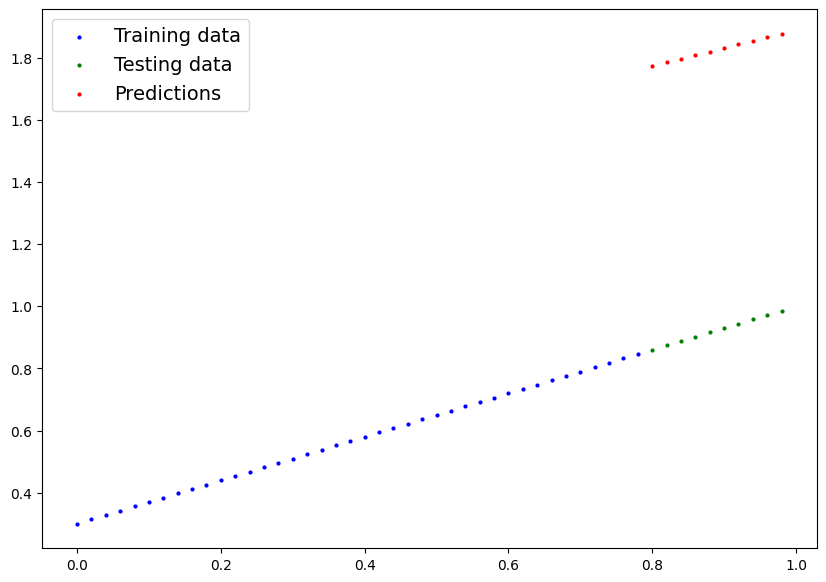

In [91]:
plot_predictions(predictions=y_preds)

### 3. train model

the idea of training is for model to move from a poor representation of the data to a better representation of the data.

one way to measure how poorly the model is predictign is to use a **loss functions** (also known as a **criterion** or **cost function**).

**Loss function**: how far model predictions are from ideal values (lower is better)

**Optimizer**: adjusts the model parameters (weights and biases) to improve loss function.

pytorch needs: training loop and testing loop.

In [107]:
# set up a loss function
loss_fn = nn.L1Loss() # mean absolute error

# set up optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) #lr -> learning rate

#### building a training loop (and a testing loop) in pytorch

0. loop throught the data
1. forward pass (involves data moving through our model's `forward` functions) also known as forward propagation
2. calculate the loss (compare forward pass predictions to ground truth labels)
3. optimizer zero grad
4. loss backward - move backwards through the network to calculate the gradient of each of the parameters of our model wrt to the loss
5. optimizer loss - use the optimizer to adjust the model's parameter to try and improve the loss (**gradient descent**)

In [16]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.5656])), ('bias', tensor([1.2948]))])

In [108]:
# an epoch is one loop through the data

epochs = 300
# tracking parameters
epoch_count = []
loss_values = []
test_loss_values = []
### Training
# 0. loop through the data
for epoch in range(epochs):
    # set the model to training mode
    model_0.train()
    # 1. forward pass
    y_pred = model_0(X_train)
    # 2. calculate the loss
    loss = loss_fn(y_pred, y_train)
    # 3. optimizer zero grad
    optimizer.zero_grad()
    # 4. perform back propagation on the loss wrt parameters
    loss.backward()
    # 5. step the optimizer (perform gradient descent)
    optimizer.step()
    # how the optimizer changes accumulates through the loop so we have to zero it above

    ### testing
    model_0.eval() # set the model to testing mode
    with torch.inference_mode(): # turns off gradient tracking & other things behind the scene
        # 1 forward pass
        test_pred = model_0(X_test)

        # 2 calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    # print out what's happening
    if epoch%10==0:
        # epoch_count.append(epoch)
        # train_loss_values.append(loss.detach().numpy())
        # test_loss_values.append(test_loss.detach().numpy())
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
        print(model_0.state_dict())

Epoch: 0 | Loss: 0.9654504656791687 | Test loss: 0.8886706233024597
OrderedDict([('weights', tensor([0.5695])), ('bias', tensor([1.3048]))])
Epoch: 10 | Loss: 0.8502405285835266 | Test loss: 0.7539607286453247
OrderedDict([('weights', tensor([0.5305])), ('bias', tensor([1.2048]))])
Epoch: 20 | Loss: 0.7350306510925293 | Test loss: 0.619251012802124
OrderedDict([('weights', tensor([0.4915])), ('bias', tensor([1.1048]))])
Epoch: 30 | Loss: 0.6198208332061768 | Test loss: 0.484541118144989
OrderedDict([('weights', tensor([0.4525])), ('bias', tensor([1.0048]))])
Epoch: 40 | Loss: 0.5046108961105347 | Test loss: 0.34983134269714355
OrderedDict([('weights', tensor([0.4135])), ('bias', tensor([0.9048]))])
Epoch: 50 | Loss: 0.38940104842185974 | Test loss: 0.21512147784233093
OrderedDict([('weights', tensor([0.3745])), ('bias', tensor([0.8048]))])
Epoch: 60 | Loss: 0.2741912007331848 | Test loss: 0.08041167259216309
OrderedDict([('weights', tensor([0.3355])), ('bias', tensor([0.7048]))])
Epoch

In [46]:
weight, bias

(0.7, 0.3)

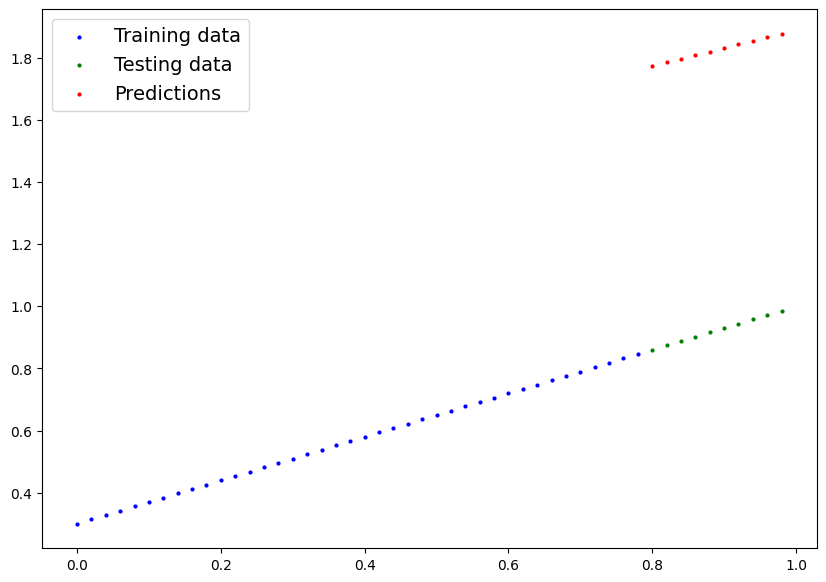

In [75]:
plot_predictions(predictions=y_preds)

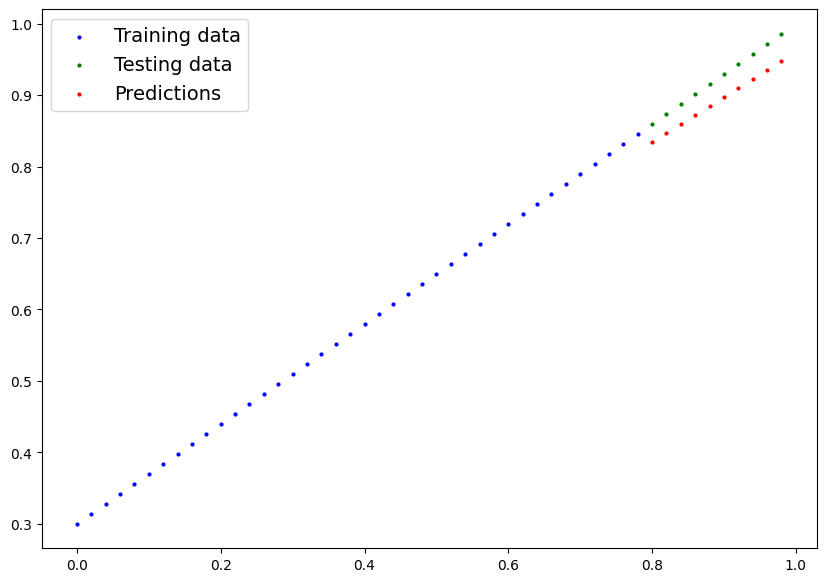

In [109]:
# making some predictions
with torch.inference_mode():
    y_preds_new = model_0(X_test)
plot_predictions(predictions=y_preds_new)

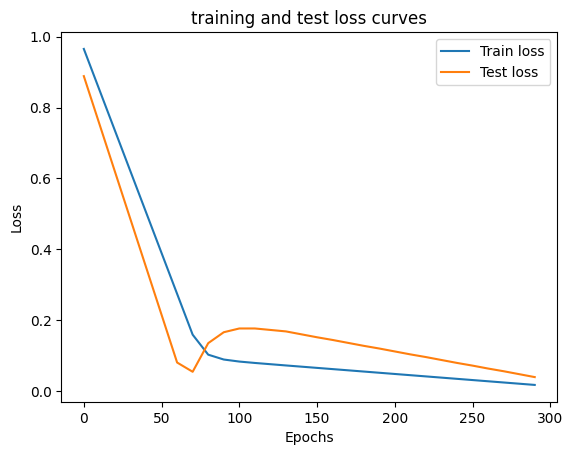

In [115]:
# plot the loss curves
import numpy as np
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()







## Save a model in Pytorch

- `torch.save()`
- `torch.load()`
- `torch.nn.Module.load_state_dict()` - a python dictionary object that maps each layer to its Parameter tensor

In [126]:
# saving our pytorch model
from pathlib import Path
# 1. create a model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2 create a model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pt" # .pth or .pt for pytorch
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
display(MODEL_SAVE_PATH)

# 3. save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

PosixPath('models/01_pytorch_workflow_model_0.pt')

Saving model to: models/01_pytorch_workflow_model_0.pt


In [125]:
%ls -l models

total 4
-rw-r--r-- 1 root root 1207 Aug  2 17:12 01_pytorch_workflow_model_0.pt


#### loading the model
We will create a new instance of our model class and load in the `state_dict`.

In [134]:
# instantiating model class
loaded_model_0 = LinearRegressionModel()
display(loaded_model_0.state_dict())
# load the saved state dict
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
# loaded_model_0.load_state_dict(torch.load \
        # ('/content/drive/MyDrive/ZTM_Pytorch_tutorial/models/01_pytorch_workflow_model_0.pt'))

OrderedDict([('weights', tensor([0.6986])), ('bias', tensor([0.5706]))])

<All keys matched successfully>

In [137]:
# compare the two
loaded_model_0.eval()
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)
    loaded_model_y_preds = loaded_model_0(X_test)
# checking if they're the same
loaded_model_y_preds == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# Putting it all together

## importing models and device agnostic code

In [149]:
# import pytorch and matplotlib
import torch
import matplotlib.pyplot as plt

# check pytorch version
display(torch.__version__)


# create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

'2.0.1+cu118'

Using device: cuda


## data preparation

In [167]:
# data
X = torch.arange(0,10,0.1).unsqueeze(dim=1)
weight, bias = 5.5,-1
y = X*weight + bias

# splitting the data into training and test
testsplit = int(0.8*len(X))
X_train, X_test = X[:testsplit], X[testsplit:]
y_train, y_test = y[:testsplit], y[testsplit:]


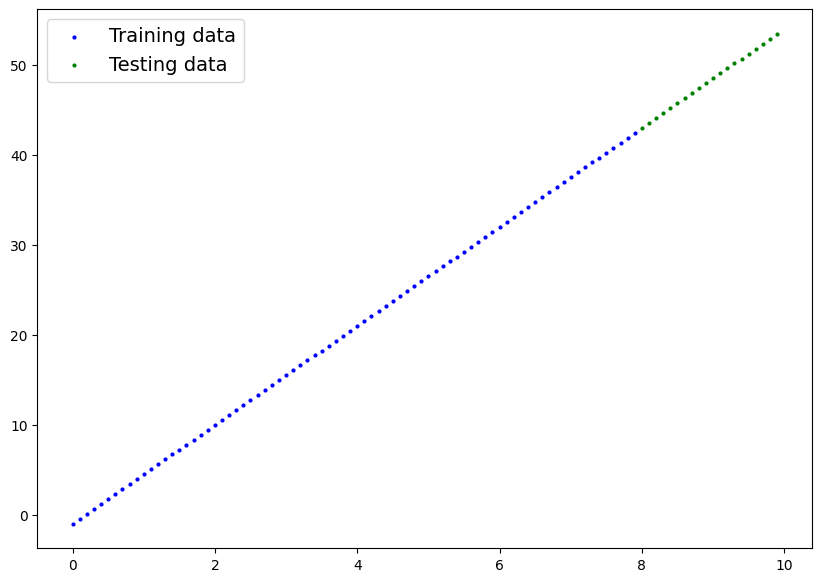

In [168]:
# plot the data
plot_predictions(X_train, y_train, X_test, y_test)

## building the linear module


In [173]:
# building the module
from torch import nn
class LinearRegModel(nn.Module):
    def __init__(self):
        super().__init__()
        # initialize the parameters
        self.weight = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    def foward(self, x:torch.Tensor) -> torch.Tensor:
        return self.weight*x + self.bias

LinearRegModel().state_dict()

OrderedDict([('weight', tensor([0.5929])), ('bias', tensor([-1.7912]))])

In [205]:
from torch import nn
class LinearReg(nn.Module):
    def __init__(self):
        super().__init__()
        # using torch.Linear() to create parameters
        # applies a linear transformation (wx + b) to the incoming data
        self.linear_layer = nn.Linear(in_features=1, # input feature, X has 1 dimension
                                      out_features=1) # outpute feature, y has 1 dimension
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

torch.manual_seed(88)
model_1 = LinearReg()
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.5461]])),
             ('linear_layer.bias', tensor([0.3875]))])

In [206]:
# set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

## training

- loss function
- optimizer
- training loop
- testing loop

In [207]:
# create optimizer function
optimizer = torch.optim.SGD(params = model_1.parameters(),
                             lr=0.01)
# create loss function
loss_fn = nn.L1Loss()

In [208]:
# training loop
torch.manual_seed(88)
epochs = 200
# put data on the target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)
for epoch in range(epochs):
    # set it to training mode
    model_1.train()
    # 1. forward pass
    y_pred = model_1(X_train)
    # 2. calculate loss
    loss = loss_fn(y_pred, y_train)
    # 3. optimize zero grad
    optimizer.zero_grad()
    # 4. backpropagation
    loss.backward() # calculate the grad for the loss function
    # 5. optimzer the loss parameters
    optimizer.step()

    ### testing
    # set the model into eval mode
    model_1.eval()
    with torch.inference_mode():
        # forward pass
        test_pred = model_1(X_test)
        # loss
        test_loss = loss_fn(test_pred, y_test)


    # print what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss}, test_loss: {test_loss}")
        print(model_1.state_dict())


Epoch: 0, loss: 18.247177124023438, test_loss: 42.58747863769531
OrderedDict([('linear_layer.weight', tensor([[0.5856]], device='cuda:0')), ('linear_layer.bias', tensor([0.3967], device='cuda:0'))])
Epoch: 10, loss: 16.612688064575195, test_loss: 38.97196960449219
OrderedDict([('linear_layer.weight', tensor([[0.9794]], device='cuda:0')), ('linear_layer.bias', tensor([0.4877], device='cuda:0'))])
Epoch: 20, loss: 14.983263969421387, test_loss: 35.36014175415039
OrderedDict([('linear_layer.weight', tensor([[1.3729]], device='cuda:0')), ('linear_layer.bias', tensor([0.5777], device='cuda:0'))])
Epoch: 30, loss: 13.361247062683105, test_loss: 31.756330490112305
OrderedDict([('linear_layer.weight', tensor([[1.7657]], device='cuda:0')), ('linear_layer.bias', tensor([0.6660], device='cuda:0'))])
Epoch: 40, loss: 11.746179580688477, test_loss: 28.158695220947266
OrderedDict([('linear_layer.weight', tensor([[2.1579]], device='cuda:0')), ('linear_layer.bias', tensor([0.7530], device='cuda:0'))])

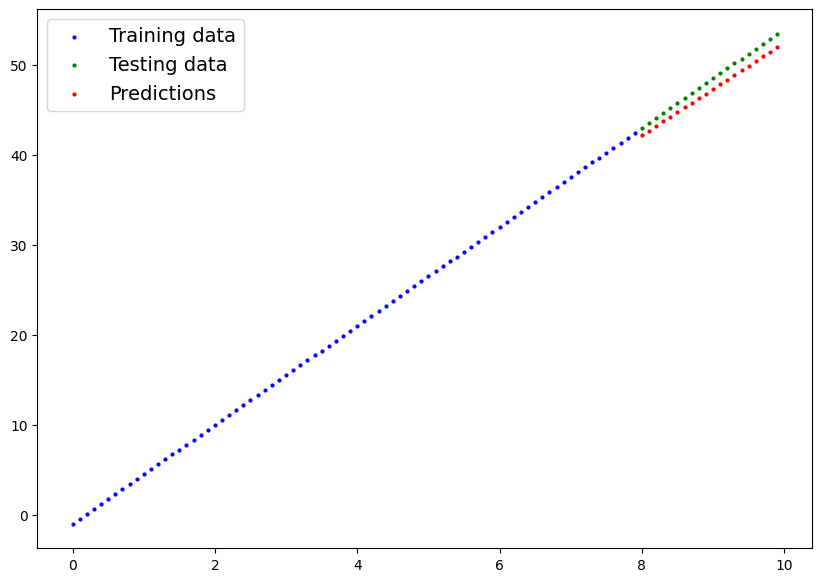

In [211]:
# making some predictions
model_1.eval()
with torch.inference_mode():
    y_preds_new = model_1(X_test)
plot_predictions(X_train.cpu(),
                 torch.Tensor.cpu(y_train),
                 torch.Tensor.cpu(X_test),
                 torch.Tensor.cpu(y_test),
                 predictions=torch.Tensor.cpu(y_preds_new))

## saving and loading

In [215]:
## saving and loading
from pathlib import Path
# create models dictionary
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "01_pytorch_workflow_model_1.pt"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

# save the state dict

torch.save(obj = model_1.state_dict(), f = MODEL_SAVE_PATH)

loaded_model_1 = LinearReg()
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [218]:
loaded_model_1.to(device)


LinearReg(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [219]:
loaded_model_1.state_dict() == model_1.state_dict()

True